# Brain MRI Segmentation

In [62]:
import scipy.io
import matplotlib.pyplot as plt
import utils


data = scipy.io.loadmat('Brain.mat')
mri_stacked = data['T1']
mri_labels = data['label']

print(mri_stacked.shape)
print(mri_labels.shape)
print(mri_labels[:,:,0].max())
print(mri_labels[:,:,0].min())

(362, 434, 10)
(362, 434, 10)
5
0


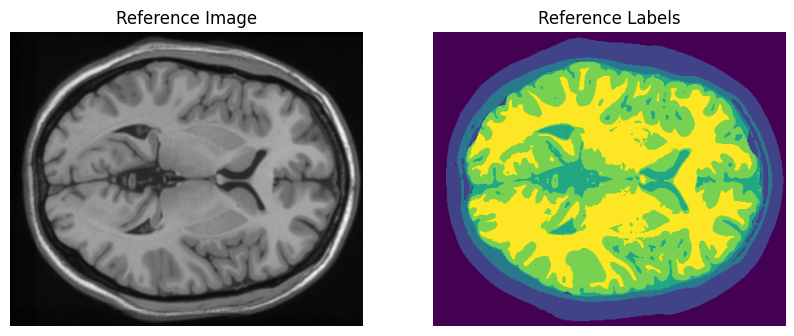

In [63]:
reference_img = mri_stacked[:,:,0]

# Normalize reference_img
reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

reference_labels = reference_labels = mri_labels[:,:,0]


utils.plot_images([reference_img,reference_labels], 
            ['Reference Image', 'Reference Labels'],
            ['gray', 'viridis'])

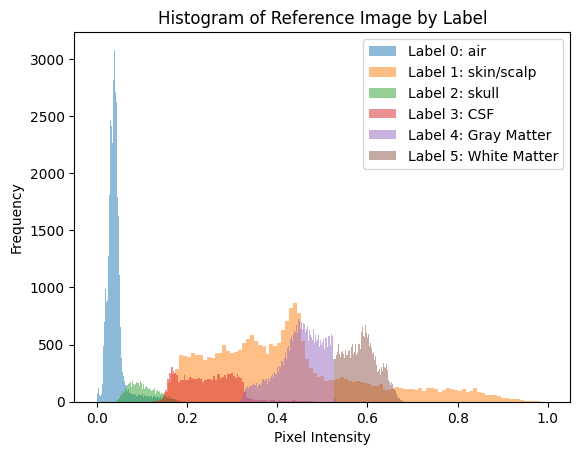

In [64]:
utils.plot_frequencies(reference_img, reference_labels)

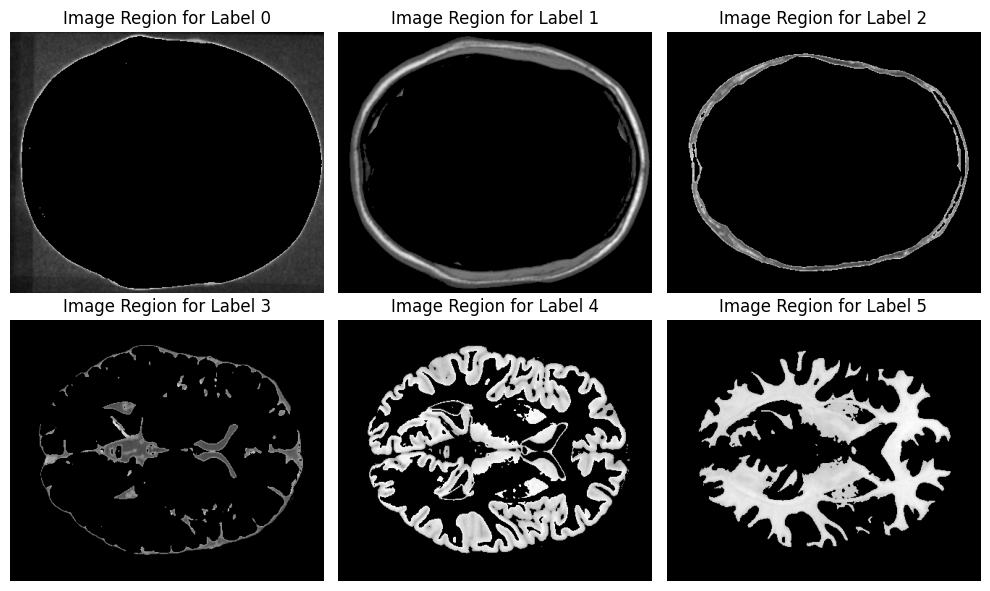

In [65]:
utils.plot_segmented_regions(reference_img, reference_labels)

# Segmentation Algorithm

In [66]:
# Relevant Libraries
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes
import scipy.ndimage as ndimage
from skimage.morphology import convex_hull_image
from sklearn.cluster import KMeans
import numpy as np

from skimage.feature import canny
from skimage.morphology import binary_opening, binary_closing, disk

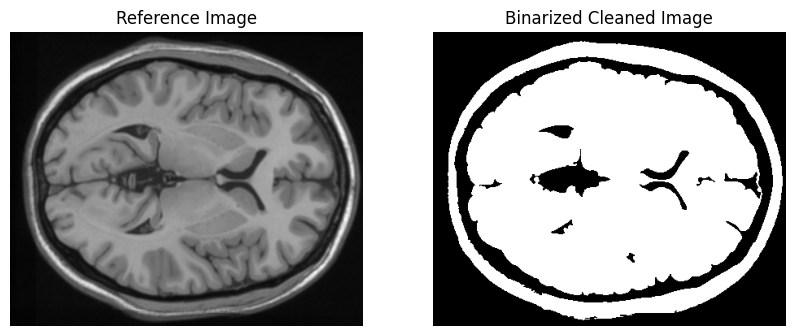

In [67]:
reference_img = mri_stacked[:,:,0]

# Normalize reference_img
reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

temporal_masks = {}

def binarizing_cleaning(reference_img):
    # Apply an outsu algorithm to the reference image
    threshold = threshold_otsu(reference_img)
    binary = reference_img > threshold - 0.02

    # Remove the smaller artificts (holes and objects)
    cleaned = remove_small_holes(binary)
    cleaned = remove_small_objects(cleaned, min_size=1000)

    return cleaned

cleaned = binarizing_cleaning(reference_img)

# Plot temporal masks
utils.plot_images([reference_img, cleaned],[ 'Reference Image', 'Binarized Cleaned Image'])

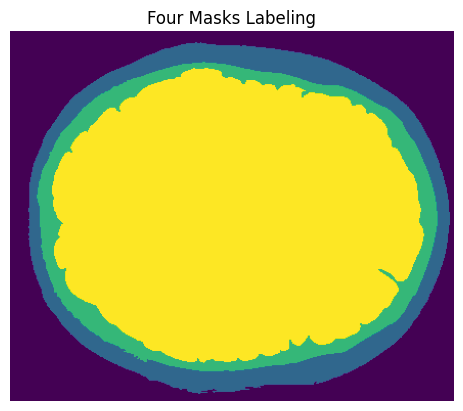

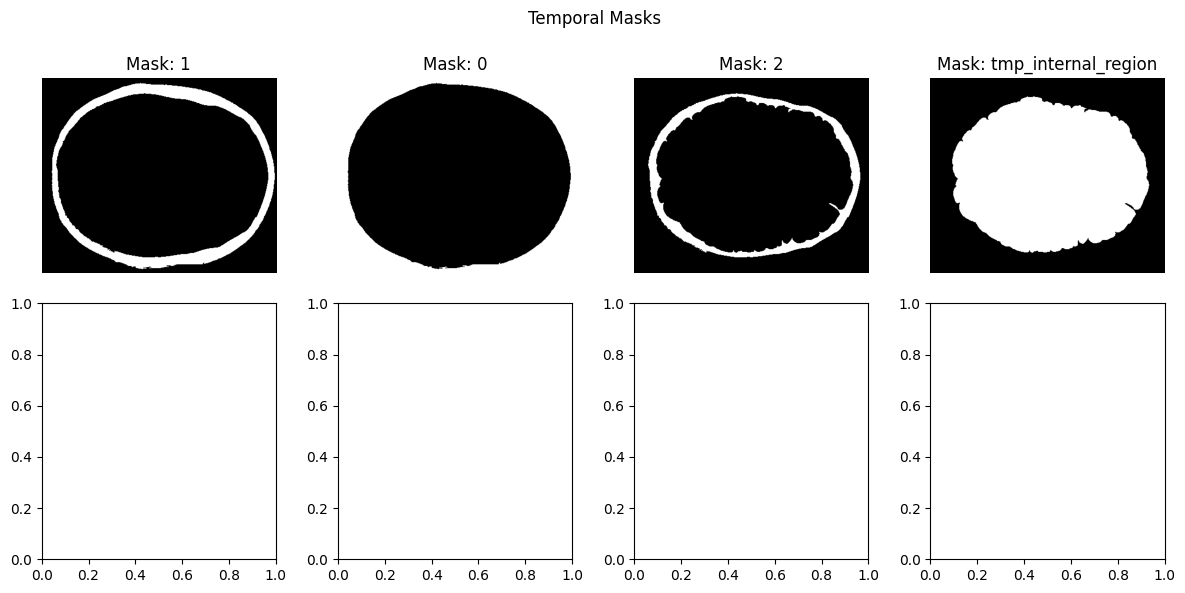

In [68]:
def four_mask_labeling(cleand, temporal_masks):
    # Apply two-pass algorithm to the cleaned image to have preliminary labels
    labels, _ = ndimage.label(cleaned)

    # NOTE: I got 3 labels, but I save only the first label
    # Save the temporal mask label 1
    temporal_masks["1"] = (labels == 1).astype(int)

    # Invert the cleaned image
    inverted = ~cleaned

    # Got the others labels from the inverted image
    # using the same two-pass algorithm
    inverted_labels, num_labels = ndimage.label(inverted)

    # Only consider the two first labels and all the other to zero
    inverted_labels[inverted_labels > 2] = 0

    # Save temporal masks label 0 and 2
    temporal_masks["0"] = (inverted_labels == 1).astype(int)
    temporal_masks["2"] = (inverted_labels == 2).astype(int)

    # Got the tmp internal region by considering all that is
    # not part of the mask 0, 1, 2
    tmp_mask = temporal_masks["0"] + temporal_masks["1"] + temporal_masks["2"]
    temporal_masks["tmp_internal_region"] = (tmp_mask == 0).astype(int)

    return temporal_masks

temporal_masks = four_mask_labeling(cleaned, temporal_masks)

# Plot the temporal_mask in a unique img
keys = ["0", "1", "2", "tmp_internal_region"]
utils.plot_temporal_masks_by_keys(temporal_masks, keys, title = "Four Masks Labeling")

# Plot temporal masks
utils.plot_masks(temporal_masks, rows=2, cols=4)


In [ ]:
def internal_mask_refinement_convex_hull(temporal_masks, reference_img):
    # Apply the convex hull to the tmo_internal_region
    binary_mask = convex_hull_image(temporal_masks["tmp_internal_region"])

    # Save the convex hull mask in the temporal masks
    temporal_masks["tmp_internal_region"] = binary_mask.astype(int)

    return binary_mask, temporal_masks

In [ ]:
def internal_mask_refinement_morphological(temporal_masks):
    # Apply binary opening to the binary image
    binary_mask = binary_closing(temporal_masks["tmp_internal_region"], disk(2))

    # Fill holes in the binary image
    binary_mask = ndimage.binary_fill_holes(binary_mask)

    # Dilate the binary image
    binary_mask = ndimage.binary_dilation(binary_mask, disk(2))

    temporal_masks["tmp_internal_region"] = binary_mask

    return binary_mask, temporal_masks

In [ ]:
def internal_mask_refinement_edges(temporal_masks, reference_img):

    # Get the edges from masked_convex_hull
    edges = canny(temporal_masks["tmp_internal_region"], sigma=2)

    # Dilate the edges
    edges = ndimage.binary_dilation(edges)

    # Fill holes in the edges
    binary_mask = ndimage.binary_fill_holes(edges)

    # remove small objects
    binary_mask = remove_small_objects(binary_mask, min_size=100)

    temporal_masks["tmp_internal_region"] = binary_mask

    return binary_mask, temporal_masks

In [ ]:
def internal_mask_refinement(temporal_masks, reference_img, method):

    if method == 'convex_hull':
        return internal_mask_refinement_convex_hull(temporal_masks, reference_img)
    elif method == 'morphological':
        return internal_mask_refinement_morphological(temporal_masks)
    elif method == 'edges':
        return internal_mask_refinement_edges(temporal_masks, reference_img)
        

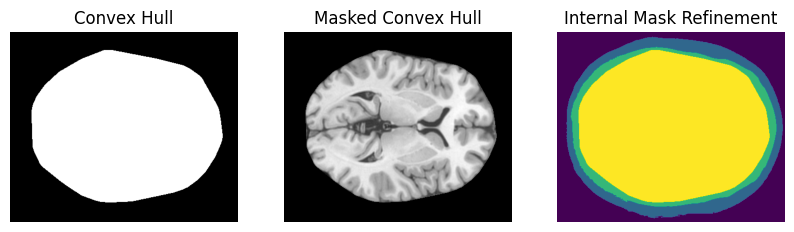

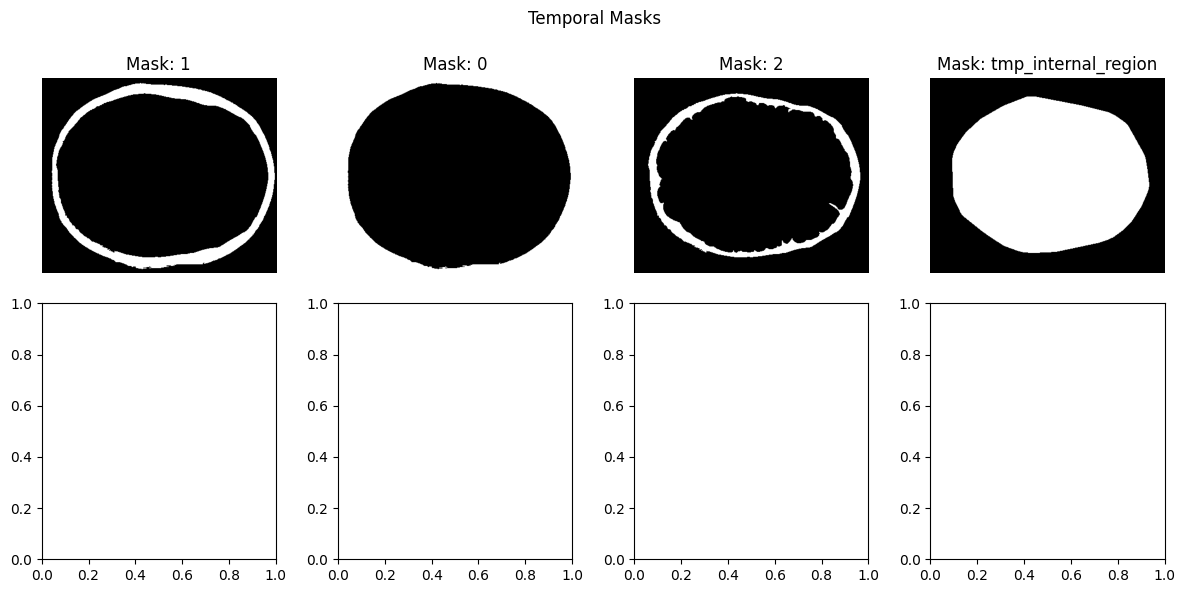

In [69]:
binary_mask, temporal_masks = internal_mask_refinement(temporal_masks, 
                                                       reference_img,
                                                       method='convex_hull')

keys = ["0", "1", "2", "tmp_internal_region"]
segemented_img = utils.plot_temporal_masks_by_keys(temporal_masks, keys, title = "Internal Mask Refinement", isPlot = False)
utils.plot_images(
    [binary_mask, reference_img * binary_mask, segemented_img],
    ['Convex Hull', 'Masked Convex Hull', 'Internal Mask Refinement'],
    ['gray', 'gray', 'viridis']
)
utils.plot_masks(temporal_masks, rows=2, cols=4)

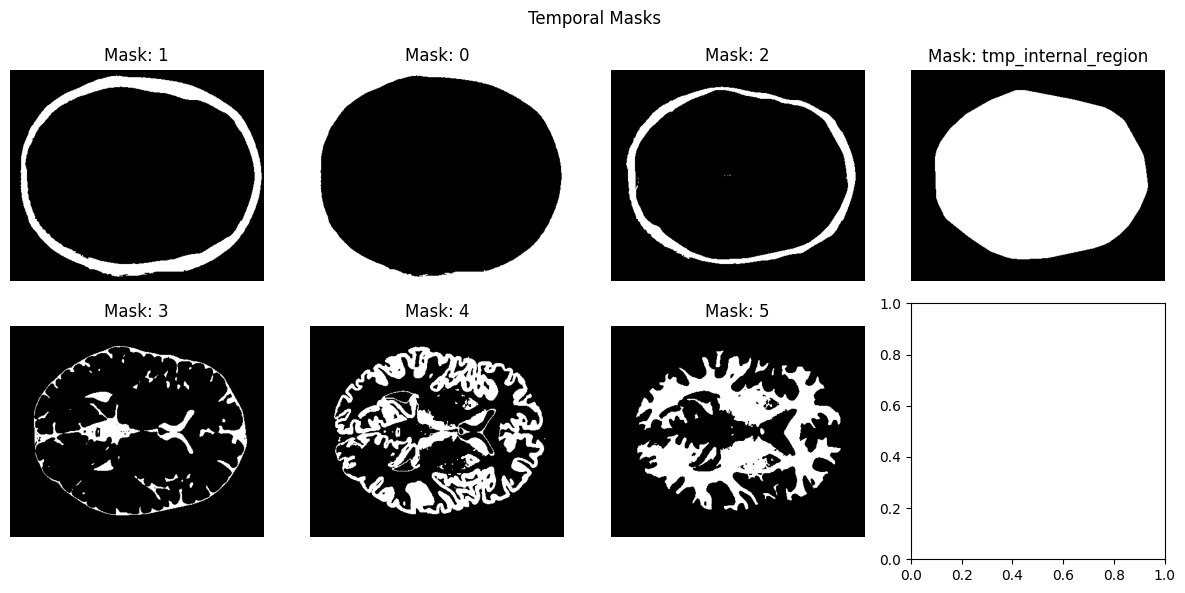

In [70]:
def internal_mask_labeling(temporal_masks, reference_img):
    # Apply the tmp_internal_region to the reference image
    masked_internal_region = reference_img * temporal_masks['tmp_internal_region']

    # Apply k-means clustering to the masked internal region
    internal_labels, order = utils.kmeans_segmentation(masked_internal_region, n_clusters=4)

    # Use the order to fit the mask 3, 4, 5
    # NOTE: I don't use order 0 because it corresponds to the external region
    temporal_masks["3"] = (internal_labels == order[1]).astype(int)
    temporal_masks["4"] = (internal_labels == order[2]).astype(int)
    temporal_masks["5"] = (internal_labels == order[3]).astype(int)

    # NOTE: There are certain difference between the convex hull 
    # and the internal region, which consequently affect the
    # k-means clustering, and mask 2. Then, I need to refine
    # the mask 2

    # Refine the mask 2 by considering all the others masks
    tmp_mask = ( temporal_masks["0"] + temporal_masks["1"] +
                temporal_masks["3"] + temporal_masks["4"] +
                temporal_masks["5"] )
    temporal_masks["2"] = (tmp_mask == 0).astype(int)

    return temporal_masks

temporal_masks = internal_mask_labeling(temporal_masks, reference_img)

# Plot the temporal masks
utils.plot_masks(temporal_masks, rows=2, cols=4)

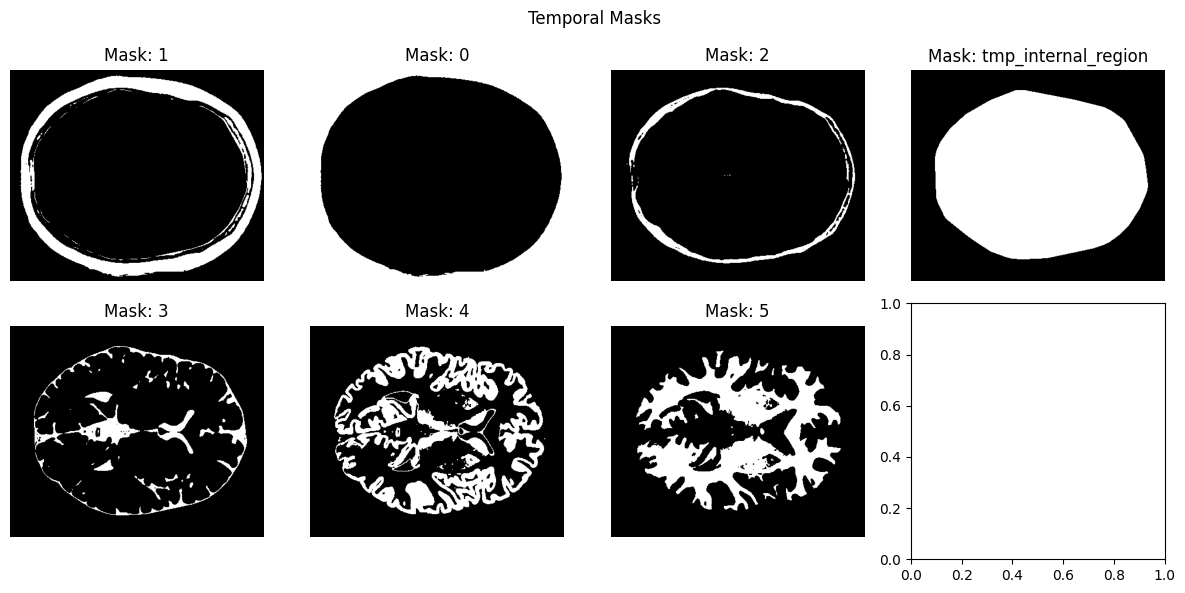

In [72]:
# NOTE: In the ground trues, the mask 1 and 2 have some
# parts in between each other. Then, I need to refine 
# these two masks

def mask_1_2_refinement(reference_img, temporal_masks):
    # Add the mask 1 and 2 in a tmp_mask
    tmp_mask = temporal_masks["1"] + temporal_masks["2"]

    # Apply tmp_mask to the reference image
    tmp_masked = reference_img * tmp_mask

    # Apply outsu algorithm to the masked image
    # NOTE: I add some constant value to the threshold
    # to improve the segmentation
    threshold = threshold_otsu(tmp_masked)
    binary = tmp_masked > threshold - 0.09

    # Add the refined mask 1 and 2 to the temporal masks
    temporal_masks["1"] = binary.astype(int)
    temporal_masks["2"] = tmp_mask - binary
    
    return temporal_masks

temporal_masks = mask_1_2_refinement(reference_img, temporal_masks)

# Plot the temporal masks
utils.plot_masks(temporal_masks, 2, 4)

Text(0.5, 1.0, 'Final Segmented Image')

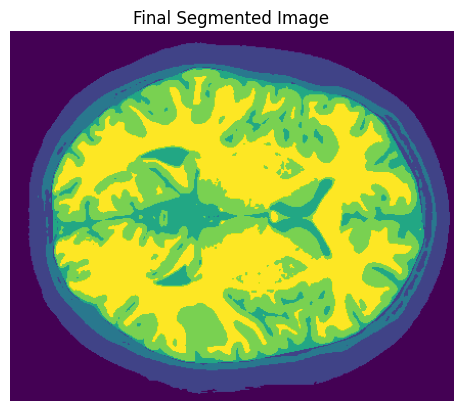

In [73]:
segmented_img = utils.temporal_masks2final_segmented_mask(temporal_masks)

# Plot the final segmented image
plt.imshow(segmented_img)
plt.axis('off')
plt.title('Final Segmented Image')

In [74]:
# Show results
metrics, metrics_by_label = utils.calculate_metrics(reference_labels, segmented_img)

print(metrics)
metrics_by_label


{'micro_jaccard': 0.8968, 'micro_dice': 0.9456, 'auprc': 0.9361, 'micro_f1': 0.9456, 'accuracy': 0.9456}


{'jaccard label 0': 0.9517,
 'f1 label 0': 0.9752,
 'auprc label 0': 0.9759,
 'jaccard label 1': 0.845,
 'f1 label 1': 0.916,
 'auprc label 1': 0.9244,
 'jaccard label 2': 0.8916,
 'f1 label 2': 0.9427,
 'auprc label 2': 0.9482,
 'jaccard label 3': 0.7192,
 'f1 label 3': 0.8367,
 'auprc label 3': 0.8438,
 'jaccard label 4': 0.8821,
 'f1 label 4': 0.9374,
 'auprc label 4': 0.9528,
 'jaccard label 5': 0.9432,
 'f1 label 5': 0.9708,
 'auprc label 5': 0.9716}

In [ ]:
# Print the number of pixels per label
for i in range(6):
    print(f"Label {i}: {np.sum(reference_labels == i)} pixels")

# NOTE: clearly we have an imbalance in the number of pixels per label

Label 0: 41630 pixels
Label 1: 24071 pixels
Label 2: 9093 pixels
Label 3: 9788 pixels
Label 4: 37858 pixels
Label 5: 34668 pixels


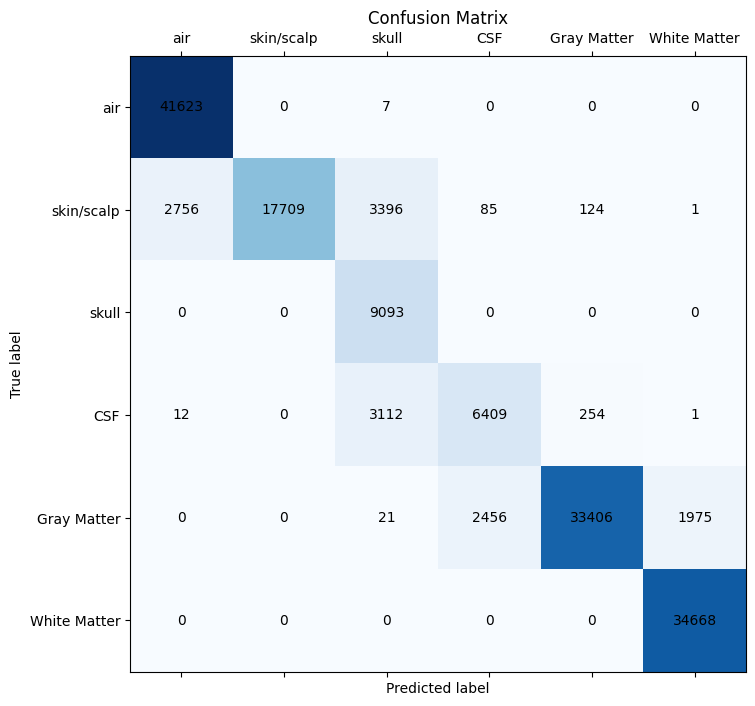

In [ ]:
utils.plot_confusion_matrix(reference_labels, segmented_img)